<a href="https://colab.research.google.com/github/ravellys/TemporalSeriesAnalyses/blob/main/RNN_Univariat_PrecCaruaru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# APLICAÇÃO DE DEEP LEARNING PARA A PREDIÇÃO DA PRECIPITAÇÃO PLUVIOMÉTRICA MENSAL NO MUNICÍPIO DE CARUARU-PE
---
Autores:  Lucas Ravellys Pyrrho de Alcântara e Jean Firmino Cardoso

---

## Justificativa
Estudos sobre a chuva e clima ganharam grande relevância em diversos setores econômicos e sociais, tendo em vista que a previsão do tempo é um fator determinante do potencial hídrico de uma região. 

## Objetivo
Nesse sentido, o objetivo desse trabalho construir um modelo de Deep Learning para a predição da precipitação mensal utilizando apenas a série de histórica de dados. 

## Metodologia
Para isto foram utilizados dados das precipitações mensais de 1960 até 2018 do município de Caruaru-PE. Esses dados foram implementados em um modelo de redes neurais artificiais (RNA) no manejo e análise das informações. Os dados foram analisados em conjunto com diferentes redes neurais utilizadas, a melhor aproximação obtida foi determinada.


# Import libs

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import numpy as np

from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


# Import data

In [2]:
path = 'drive/My Drive/ML_PrecCaruaru/PrecCaruaruIPAMensal.csv'
df = pd.read_csv(path, sep = ';')
df.tail()

,ano,mes,P,P_1,P_2,P_3,enos,enos_1,enos_2,enos_3
703,2018,8,14.9,32.9,40.3,62.6,0.2,0.1,0.1,-0.1
704,2018,9,10.9,14.9,32.9,40.3,0.4,0.2,0.1,0.1
705,2018,10,3.8,10.9,14.9,32.9,0.7,0.4,0.2,0.1
706,2018,11,8.1,3.8,10.9,14.9,0.9,0.7,0.4,0.2
707,2018,12,14.1,8.1,3.8,10.9,0.8,0.9,0.7,0.4


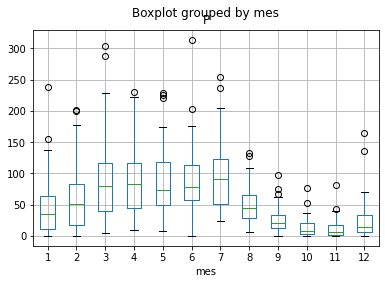

In [3]:
df.boxplot(column=['P'],by = 'mes')

A maior parte da precipitação está concentrada entre Fevereiro e Julho

In [4]:
def plot_series(time, series, format="-", start=0, end=None, label = None):
    plt.plot(time[start:end], series[start:end], format, label = label)
    plt.xticks(fontsize = 16)
    plt.legend()
    plt.xlabel("Time")
    plt.yticks(fontsize = 16)
    plt.ylabel("Value")
    plt.grid(True)    

No handles with labels found to put in legend.


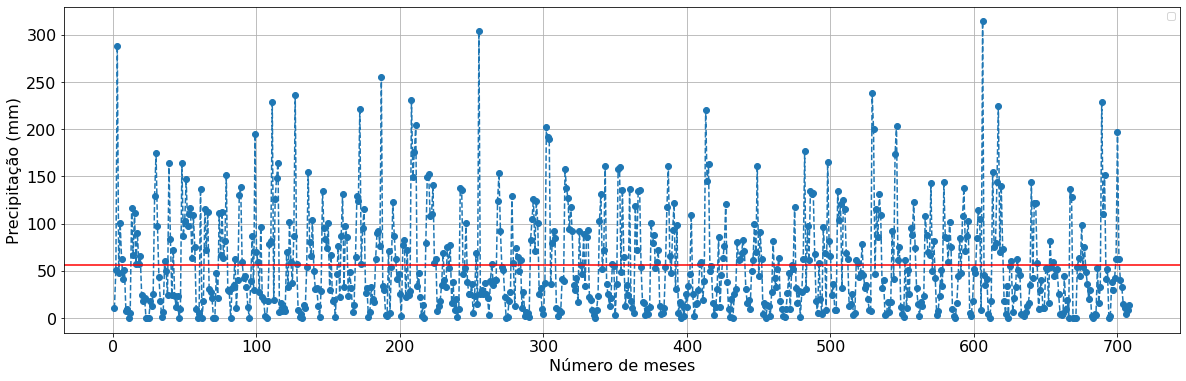

In [5]:
plt.figure(figsize=(20, 6))
plot_series(np.linspace(1,len(df),len(df)),df.P,'o--')
plt.xlabel("Número de meses", fontsize = 16)
plt.ylabel("Precipitação (mm)", fontsize = 16)
plt.axhline(y=df.P.values.mean(), c = 'r')

# Normalizando os dados

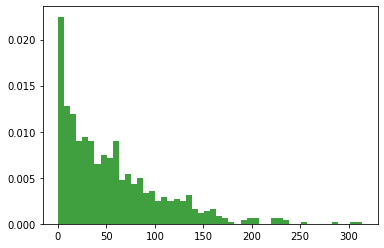

Média 3.4891077098235845
DesvPad 1.2820957051512964


In [7]:
series = df.P
plt.hist(series, 50, density=True, facecolor='g', alpha=0.75)
plt.show()

time = np.linspace(1,len(df),len(df))
percent_train = .7
split_time = int(percent_train*len(df))

ln_series = np.log(series+1)
x_train = ln_series[:split_time]
xm = x_train.mean()
Sx = x_train.std()

print("Média", xm)
print("DesvPad",Sx)

series = (ln_series - xm)/Sx

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 12
batch_size = 20
shuffle_buffer_size = 1000

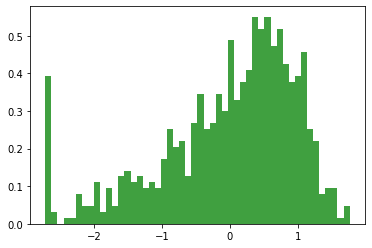

In [8]:
plt.hist(series, 50, density=True, facecolor='g', alpha=0.75)
plt.show()

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  ###
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [10]:
def Lr(epoch):
    return min(1e-4 * 10**(epoch / 100), 1e-5)
 

In [11]:
def function_lambda(x, media, desvio): 
  beta = media - 0.45*desvio
  alfa = desvio/1.283
  #return media*tf.keras.backend.log(1/x)
  #return beta - alfa*tf.keras.backend.log(-tf.keras.backend.log(1-x)) 
  return 350*x   

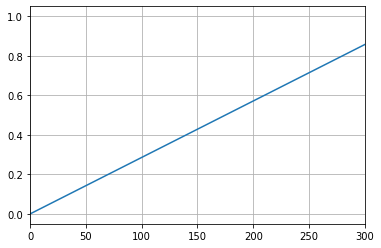

In [12]:
x = np.linspace(0,1,100)
a = function_lambda(x, df.P.values.mean(), df.P.values.std())
plt.plot(a,x)
plt.xlim([0,300])
plt.grid()

In [13]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
val_data_single = windowed_dataset(x_valid, window_size, batch_size, 1)


# Modelando a RNN

In [14]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  
 # CNN                    
  tf.keras.layers.Conv1D(filters=12, kernel_size=3, strides=1, activation="relu"),      
  #tf.keras.layers.Conv1D(filters=12, kernel_size=3, strides=1, activation="relu"),                    
  
  # RNN            
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24, return_sequences=True)),
  #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(12, return_sequences=True )),
  #tf.keras.layers.Bidirectional(tf.keras.layers.GRU(24, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(24, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(12)),


  # DNN
  #tf.keras.layers.Dense(24, activation = 'relu'),
  #tf.keras.layers.Dense(12, activation = 'relu'),
  tf.keras.layers.Dense(1, activation = 'tanh'),
  
  tf.keras.layers.Lambda(lambda x:  3.5 * x ) #function_lambda(x, xm, Sx) )
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: Lr(epoch))
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.3)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

history = model.fit(dataset,
                    verbose=0,
                    epochs=3000,                    
                    validation_data = val_data_single
                    )

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 12)          48        
_________________________________________________________________
bidirectional (Bidirectional (None, None, 48)          7104      
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 48)          3504      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 24)                1464      
_________________________________________________________________
dense (Dense)                (None, 1)                 25        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0

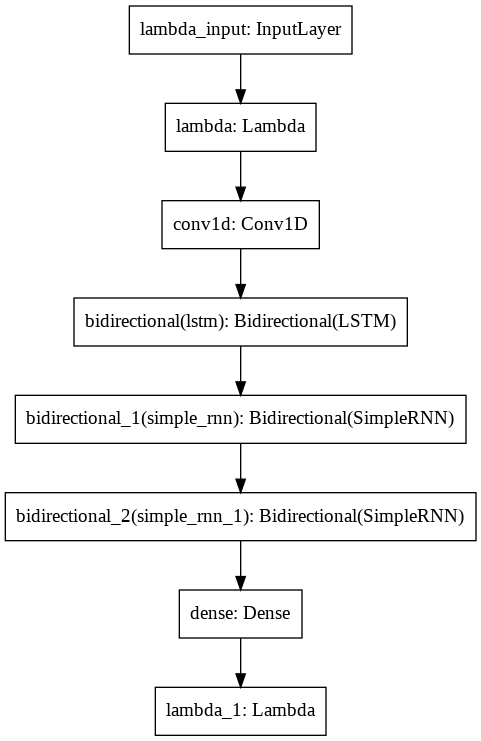

In [16]:
tf.keras.utils.plot_model(model)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


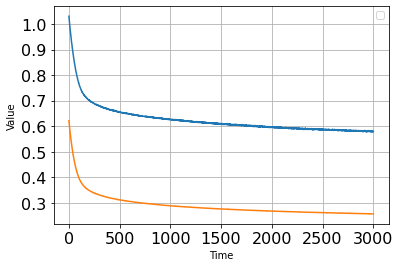

No handles with labels found to put in legend.
No handles with labels found to put in legend.


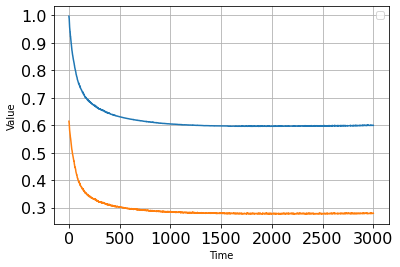

In [17]:
t = np.linspace(1,len(history.history["mae"]), len(history.history["mae"]))
plot_series(t, history.history["mae"])
plot_series(t, history.history["loss"])
plt.show()

plot_series(t, history.history["val_mae"])
plot_series(t, history.history["val_loss"])
plt.show()

In [18]:
serie = series.values
forecast = []
results = []
for time in range(len(serie) - window_size):
  serie_predict = serie[time:time + window_size][np.newaxis]
  forecast.append(model.predict(serie_predict))

In [19]:
def inv_norm(x,xm,Sx):
  return np.exp(x*Sx+xm)-1

In [20]:
df_forecast = pd.DataFrame(np.array(forecast).ravel(), columns = ["Pest"] )
df_forecast["mes"] = df.mes.values[window_size:]
df_forecast["Preal"] = serie[window_size:]

df_forecast.tail()

,Pest,mes,Preal
691,-0.135189,8,-0.563756
692,-1.026046,9,-0.789777
693,-1.639360,10,-1.497932
694,-1.086723,11,-0.999015
695,-0.049399,12,-0.604021


In [21]:
forecast_ = forecast[split_time-window_size:]
results = np.array(forecast_)[:, 0, 0]
df_forecast_val = df_forecast[split_time-window_size:]

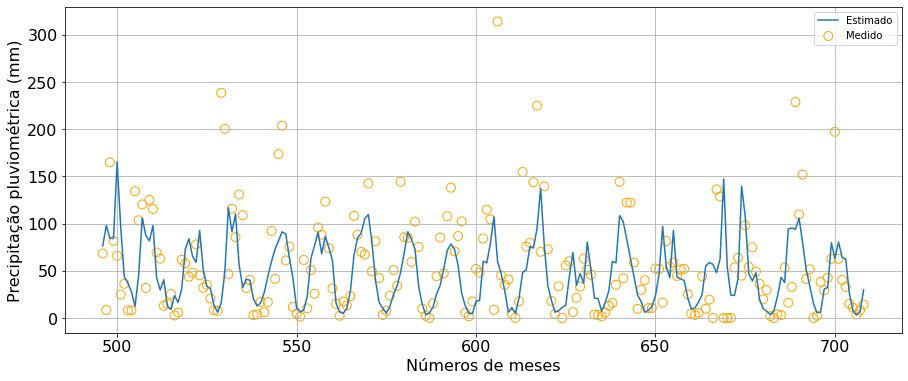

In [22]:
plt.figure(figsize=(15, 6))
plt.scatter(time_valid, inv_norm(x_valid,xm,Sx), s=80, facecolors='none', edgecolors='orange', label = 'Medido')
plot_series(time_valid, inv_norm(results,xm,Sx),label = 'Estimado' ) 
plt.xlabel("Números de meses", fontsize = 16) 
plt.ylabel("Precipitação pluviométrica (mm)", fontsize = 16) 
plt.show()

# Metricas de ajuste

NSE = 0.3216194023482556
MAE = 0.6078917


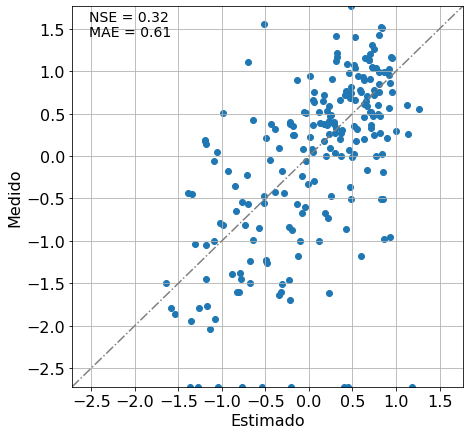

In [23]:
Min = series.min()
Max = series.max() 

plt.figure(figsize=(7,7))
plt.scatter(results, x_valid)
plt.plot([Min,Max],[Min,Max],'-.', c = 'gray')
plt.ylim([Min,Max])
plt.xlim([Min,Max])
plt.xticks(fontsize = 16)
plt.xlabel("Estimado", fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel("Medido", fontsize = 16)
plt.grid(True)

def NSE(Yobs, Ysim):
  Yobs_m = np.mean(Yobs)
  s = np.sum((Yobs - Ysim)**2)
  i = np.sum((Yobs - Yobs_m)**2)
  return 1 - s/i
  
plt.text(Min+.2,.9*Max,"NSE = %.2f"%(NSE(x_valid, results)), size = 14)
plt.text(Min+.2,.8*Max,"MAE = %.2f"%(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()), size = 14)

print('NSE =',NSE(x_valid, results))
print('MAE =', tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

# Conclusões

Mesmo obtendo resultados interessantes, a quantidade de dados não foi suficiente para o processamento eficaz almejado, com base nos resultados das métricas de quantificação, ou seja, os coeficientes MAE e NSE.

Mesmo assim, ainda foi possível prever as tendências de ausência de chuvas, de acordo com os dados, foi possível identificar padrões cíclicos para os meses com baixo volume de chuva, especialmente entre o mês de novembro. Também foi possível identificar os meses entre março e julho com as maiores probabilidades de ocorrer eventos de grandes volumes de precipitações pluviométricas ao ano.

Nesse sentido, uma análise multivariada da precipitação, levando em consideração a temperatura do oceano atlântico e o efeito do el niño/la niña podem melhorar significativamente a predição do modelo.
